In [2]:
here::i_am("rna_atac/differential/RNA.ipynb")

source(here::here("settings.R"))
source(here::here("utils.R"))

suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(edgeR))


BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 21

# Multi core using future - built in to seurat
plan("multicore", workers = 16)
options(future.globals.maxSize = 50 * 1024 ^ 3) # for 50 Gb RAM

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/code

Warning message:
“package ‘rtracklayer’ was built under R version 4.2.3”


In [3]:
args = list()

# Metadata
args$metadata = file.path(io$basedir, 'results/rna_atac/clustering/metadata_celltype_annotated_v2.txt.gz')

# RNA_sce
args$rna_sce = file.path(io$basedir, 'processed/rna/SingleCellExperiment.rds')

# outdir
args$outdir = file.path(io$basedir, 'results/rna_atac/differential/markers/')
dir.create(args$outdir, recursive=TRUE, showWarnings =FALSE)

In [7]:
# Load meta
meta = fread(args$metadata)

In [8]:
table(meta$genotype)


   KO    WT 
11856 19740 

#### Load Data

In [9]:
# load sce
rna.sce <- load_SingleCellExperiment(args$rna_sce, normalise = TRUE, cells = meta$cell)
colData(rna.sce) = meta %>% as.data.frame() %>% tibble::column_to_rownames('cell') %>% DataFrame()

In [10]:
# Prepare mofa umap
umap.dt = meta[,c('cell', 'UMAP1', 'UMAP2', 'genotype')] %>% 
    .[match(colnames(rna.sce), cell),]

### Figure 1 UMAPs

In [12]:
# Fig 2B UMAPs
p1 = ggplot(meta[genotype == 'WT'][sample(nrow(meta[genotype == 'WT']))], aes(UMAP1, UMAP2, color=day)) + 
    # ggrastr::rasterise(geom_point(size = -0.25, color='black'), dpi = 600) + 
    ggrastr::rasterise(geom_point(size = -0.1), dpi = 900) + 
    scale_color_manual(values=opts$days.colors, guide = guide_legend(override.aes = list(size = 1))) + 
  #  ggtitle('Day') + 
    scale_x_continuous(expand=c(0.01,0.01)) + 
    scale_y_continuous(expand=c(0.01,0.01)) + 
    coord_fixed() + 
    theme_void() + 
    theme(legend.position = c(0.1, 0.8),
          legend.text = element_text(size = 6, margin = margin(l = -5)),
          legend.title = element_blank(),
          legend.key.size = unit(2, "mm"),
  #        plot.title = element_text(size=8, hjust=0.5, vjust=0, face='plain')
)


meta$genotype = gsub('KO', 'Eomes-KD', meta$genotype)
opts$genotype.colors = c('WT' = 'black', 'Eomes-KD' = 'red')

p2 = ggplot(meta[sample(nrow(meta))], aes(UMAP1, UMAP2, color=genotype)) + 
    # ggrastr::rasterise(geom_point(size = -0.25, color='black'), dpi = 600) + 
    ggrastr::rasterise(geom_point(size = -0.3), dpi = 900) + 
    scale_color_manual(values=opts$genotype.colors, guide = guide_legend(override.aes = list(size = 1))) + 
 #   ggtitle('Condition') + 
    scale_x_continuous(expand=c(0.01,0.01)) + 
    scale_y_continuous(expand=c(0.01,0.01)) + 
    coord_fixed() + 
    theme_void() + 
    theme(legend.position = c(0.2, 0.8),
          legend.text = element_text(size = 6, margin = margin(l = -5)),
          legend.title = element_blank(),
          legend.key.size = unit(2, "mm"),
  #        plot.title = element_text(size=8, hjust=0.5, vjust=0, face='plain')
)

meta = meta[,celltype_v2 := factor(celltype_v2, levels = rev(names(opts$celltype_v2.colors)))]
meta$celltype_v2_figure = opts$celltype_v2_figure[match(meta$celltype_v2, names(opts$celltype_v2_figure))]
p3_labels = meta %>% copy() %>%
    .[,`:=`(UMAP1 = median(UMAP1),
            UMAP2 = median(UMAP2)), 
      by = 'celltype_v2_figure'] %>% 
    unique(by = 'celltype_v2_figure')


p3 = ggplot(meta[genotype == 'WT'][sample(nrow(meta[genotype == 'WT']))], aes(UMAP1, UMAP2, color=celltype_v2_figure)) + 
    # ggrastr::rasterise(geom_point(size = -0.25, color='black'), dpi = 600) + 
    ggrastr::rasterise(geom_point(size = -0.1), dpi = 900) + 
    scale_color_manual(values=opts$celltype_v2.colors2) + 
    ggrepel::geom_text_repel(data = p3_labels, aes(label = celltype_v2_figure),
                             color = 'black',
                             size = 2, 
                             box.padding = 0.25,
                             bg.color='white', 
                             bg.r = 0.1,
                             # nudge_y = -0.3,
                             direction = "y",
                             min.segment.length = 0,
                             segment.size = 0.3,
                             #max.overlaps = Inf,
                             seed = 1) +
    scale_x_continuous(expand=c(0.01,0.01)) + 
    scale_y_continuous(expand=c(0.01,0.01)) + 
    coord_fixed() + 
   # ggtitle('Cell type') + 
    theme_void() + 
    theme(#text = element_text(size = 6),
          legend.position = 'none',
          legend.title = element_blank(),
  #        plot.title = element_text(size=8, hjust=0.5, vjust=0, face='plain')
)

options(repr.plot.width=4, repr.plot.height=5)
# ggarrange(p3,
#           ggarrange(p1, NULL, p2, widths = c(1,0,1), nrow = 1), ncol = 1, heights = c(2,1.2))

In [13]:
# ggsave(file.path(io$basedir, 'figures/multiome_umap.pdf'), 
#        plot = ggarrange(p3,
#           ggarrange(p1, NULL, p2, widths = c(1,0,1), nrow = 1), ncol = 1, heights = c(2,1.2)), 
#        width = 55, 
#        height = 70, 
#        units = "mm")

In [17]:
ggsave(file.path(io$basedir, 'figures/multiome_umap_WT.pdf'), 
       plot = ggarrange(p3, NULL, p1, ncol = 1, heights = c(1,-0.1,1)), 
       width = 55, 
       height = 90, 
       units = "mm")

In [135]:
ggsave(file.path(io$basedir, 'figures/multiome_umap_KD.pdf'), 
       plot = p2,
       width = 55, 
       height = 70, 
       units = "mm")

### Figure S3 - UMAPs

In [11]:
head(umap.dt)

cell,UMAP1,UMAP2,genotype
<chr>,<dbl>,<dbl>,<chr>
1A_Eo_DEG_G9_day3#AAACAGCCAGCAAGAT-1,-6.742873,-4.051344,WT
1A_Eo_DEG_G9_day3#AAACAGCCAGCACCAT-1,-5.456130,-2.490946,WT
1A_Eo_DEG_G9_day3#AAACATGCAAGTAAGC-1,-6.348085,-4.264254,WT
1A_Eo_DEG_G9_day3#AAACATGCAATATACC-1,-6.044776,-2.846936,WT
1A_Eo_DEG_G9_day3#AAACATGCAATCCTGA-1,-4.960897,-3.201840,WT
1A_Eo_DEG_G9_day3#AAACATGCACTTAGGC-1,-5.634477,-2.450560,WT


In [12]:
plot_gene = function(gene){
    plot.dt = umap.dt %>% copy() %>% 
        .[, gene := as.vector(logcounts(rna.sce[gene,cell]))] %>%
        .[order(gene)] %>% 
        .[genotype == 'WT']
    
    p = ggplot(plot.dt, aes(UMAP1, UMAP2, color = gene)) + 
        ggrastr::rasterise(geom_point(size = -0.3), dpi = 900) + 
        viridis::scale_color_viridis(breaks = c(0,max(plot.dt$gene)), labels = c('Min', 'Max'), name = 'Expr.') + 
        guides(
            colour = guide_colourbar(
                barwidth = 0.3, barheight = 1,
                frame.colour = "black", 
                ticks.colour = "black"
        )) + 
        ggtitle(gene) +
        # facet_wrap(~genotype, nrow = 2) + 
        theme_void() + 
        coord_fixed() + 
        theme(legend.position = c(0.1, 0.8),
                legend.title = element_text(vjust=0, size = 7),
                legend.margin = margin(0, 0, 0, 0),  # Adjust the margin inside the legend box
                legend.box.margin = margin(0, 0, 0, 0),  # Adjust the margin outside the legend box
                legend.key.size  = unit(1, "mm"),
                legend.key = element_blank(),
                text=element_text(size=6),
                plot.title = element_text(size=8, face='plain', hjust=0.5, vjust = 0),
)
    
    return(p)
     
}

In [13]:
plots_list = mclapply(c('Kdr', 'Pdgfra', 'Eomes', 'Runx1', 'Cdh5'), plot_gene, mc.cores = 4)

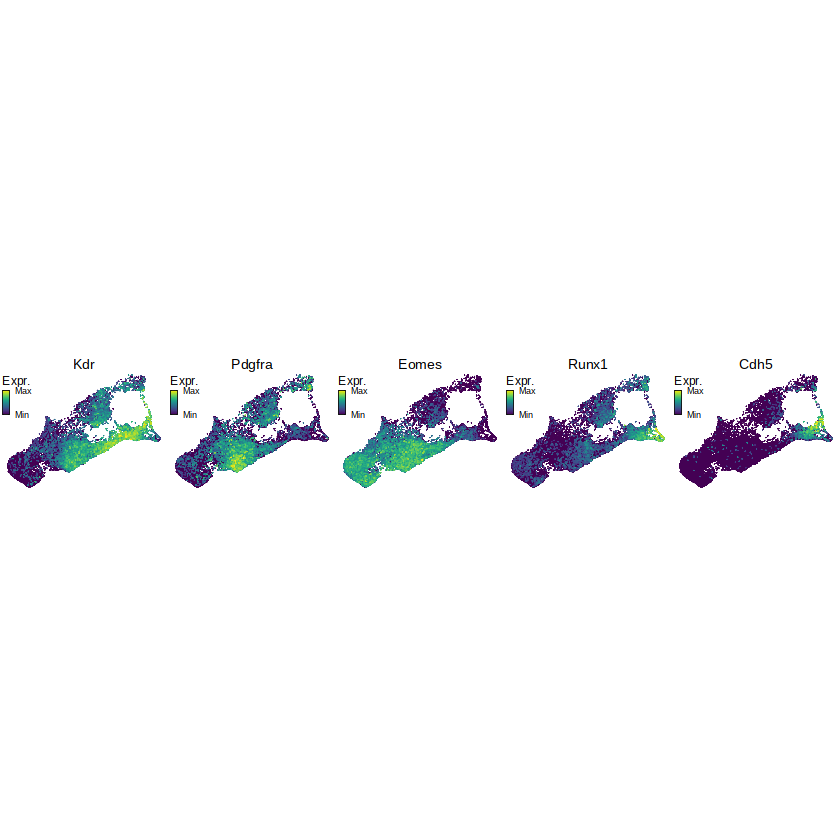

In [14]:
p = ggarrange(plotlist = plots_list, align = 'hv', nrow = 1)
p 

ggsave(file.path(io$basedir, 'figures/multiome_WT_FACScomparison.pdf'), 
       p,
       width = 165, 
       height = 30, 
       units = "mm")

# Junk

In [7]:
colnames(meta)

[1] "cell"                         "barcode"                     
 [3] "sample"                       "nFeature_RNA"                
 [5] "nCount_RNA"                   "mitochondrial_percent_RNA"   
 [7] "ribosomal_percent_RNA"        "alias"                       
 [9] "day"                          "genotype"                    
[11] "replicate"                    "pass_rnaQC"                  
[13] "doublet_score"                "doublet_call"                
[15] "celltype.mapped_mnn"          "celltype.score_mnn"          
[17] "celltype_extended.mapped_mnn" "celltype_extended.score_mnn" 
[19] "stage.mapped_mnn"             "cellstage.score_mnn"         
[21] "closest.cell_mnn"             "celltype_genotype"           
[23] "celltype_extended_genotype"   "UMAP1"                       
[25] "UMAP2"                        "mofa_cluster"                
[27] "celltype_v1"                  "celltype_v2"

In [8]:
# Projection on atlas
atlas_meta = fread(io$rna.atlas.metadata)[, c('cell', 'umapX', 'umapY')] %>% setnames('cell', 'closest.cell_mnn')
tmp = merge(meta, atlas_meta, by = 'closest.cell_mnn') %>% 
    .[, genotype := gsub('KO', 'KD', genotype)] %>% 
    .[, genotype := factor(genotype, levels = c('WT', 'KD'))]

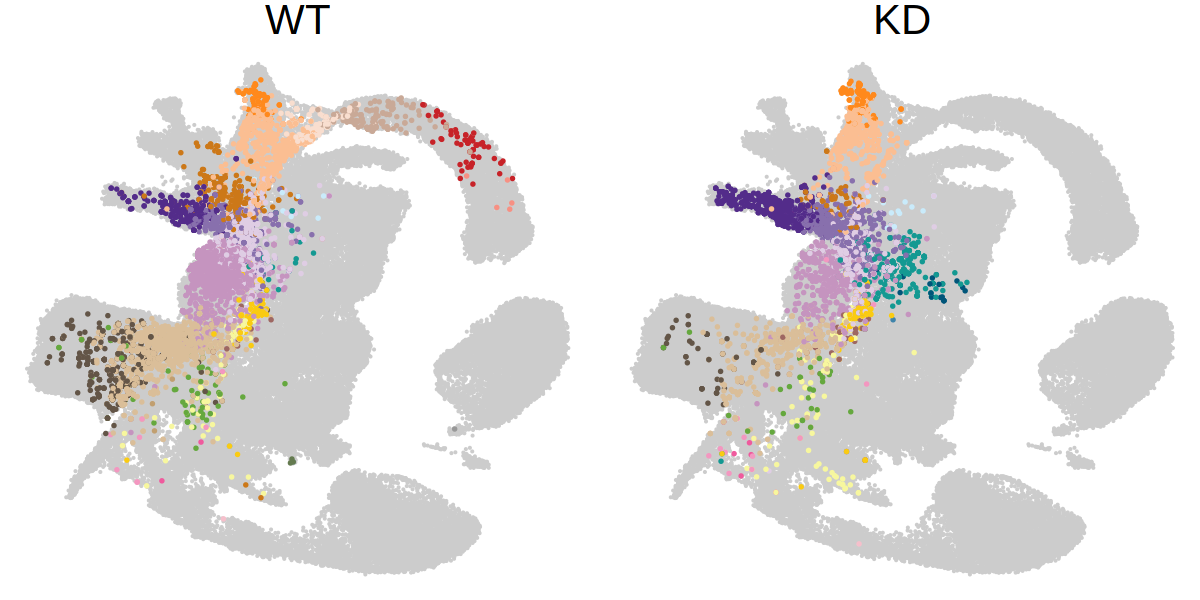

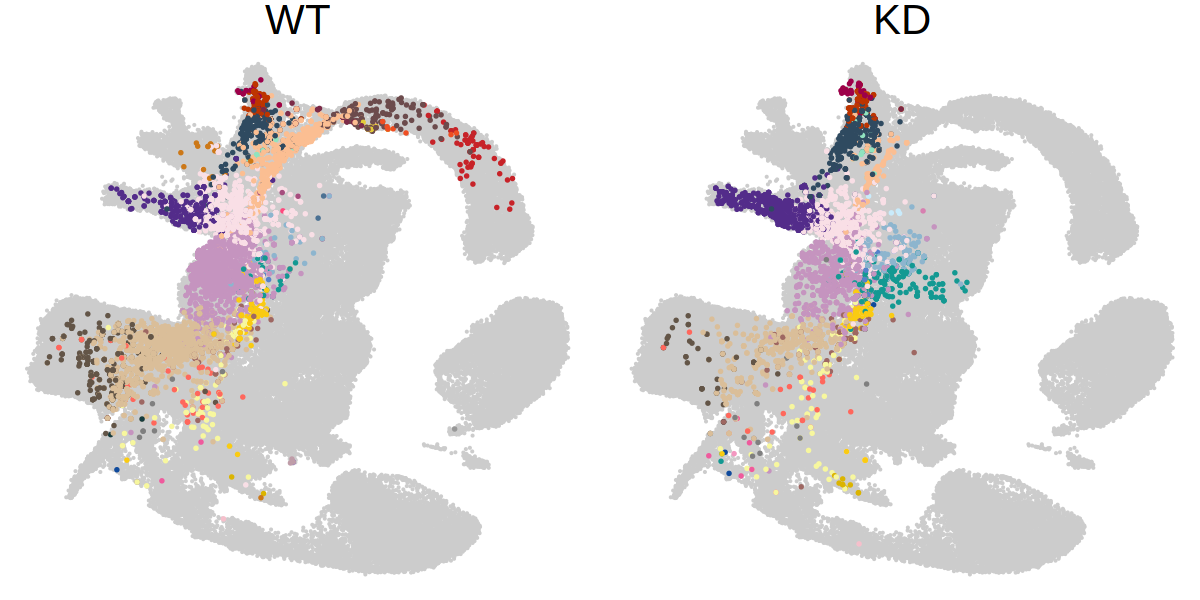

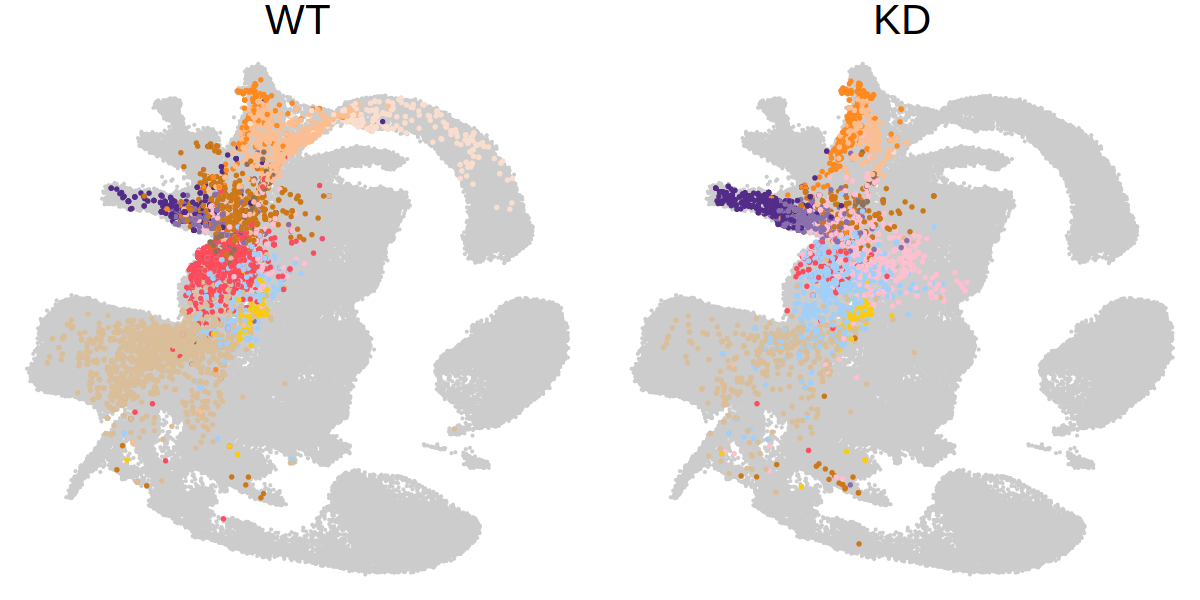

In [9]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(tmp, aes(umapX, umapY, color=celltype.mapped_mnn)) + 
    geom_point(data = atlas_meta, color = 'grey80', size = 0.1) + 
    geom_point(size = 0.5) +
    scale_color_manual(values = opts$celltype.colors) + 
    facet_wrap(~genotype) + 
    theme_void() + 
    theme(legend.position = 'none',
          strip.text = element_text(size = 25))

ggplot(tmp, aes(umapX, umapY, color=celltype_extended.mapped_mnn)) + 
    geom_point(data = atlas_meta, color = 'grey80', size = 0.1) + 
    geom_point(size = 0.5) +
    scale_color_manual(values = opts$celltype_extended.colors) + 
    facet_wrap(~genotype) + 
    theme_void() + 
    theme(legend.position = 'none',
          strip.text = element_text(size = 25))

ggplot(tmp, aes(umapX, umapY, color=celltype_v2)) + 
    geom_point(data = atlas_meta, color = 'grey80', size = 0.1) + 
    geom_point(size = 0.5) +
    scale_color_manual(values = opts$celltype_v2.colors) + 
    facet_wrap(~genotype) + 
    theme_void() + 
    theme(legend.position = 'none',
          strip.text = element_text(size = 25))


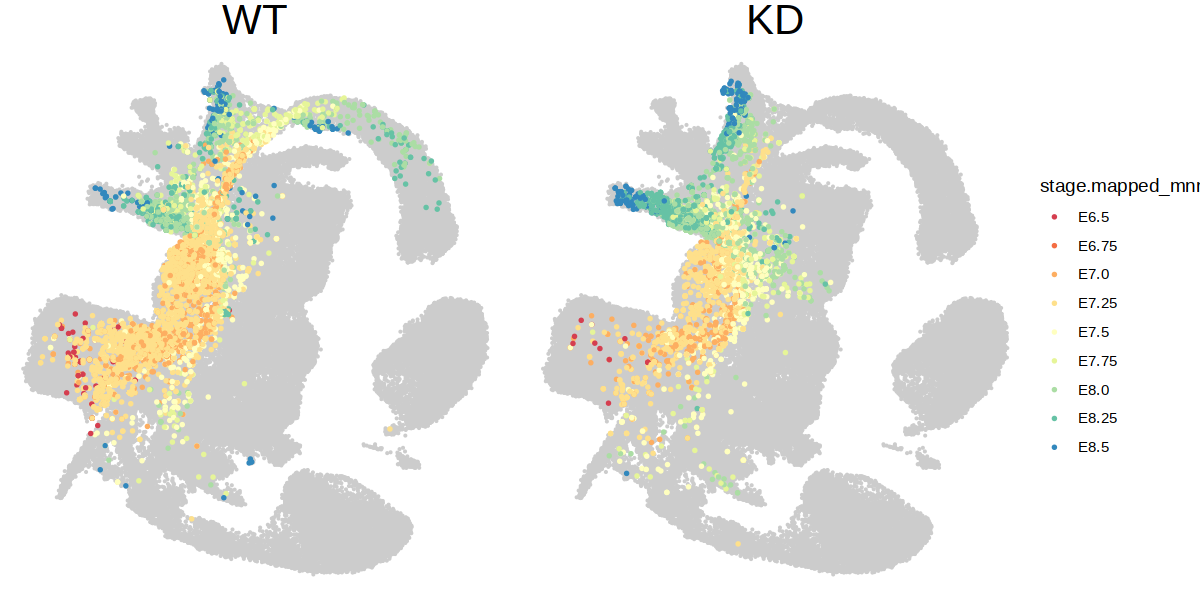

In [24]:
ggplot(tmp, aes(umapX, umapY, color=stage.mapped_mnn)) + 
    geom_point(data = atlas_meta, color = 'grey80', size = 0.1) + 
    geom_point(size = 0.5) +
    scale_color_manual(values = opts$stage.colors.original) + 
    facet_wrap(~genotype) + 
    theme_void() + 
    theme(legend.position = 'right',
          strip.text = element_text(size = 25))


In [10]:
celltype_proportions = meta %>% copy() %>%
    .[,Ntot := .N, by = c('day', 'genotype')] %>%
    .[,proportion := .N/Ntot, by = c('day', 'genotype', 'celltype_v2')] %>% 
    unique(by = c('day', 'genotype', 'celltype_v2')) %>% 
   .[,celltype_v2 := factor(celltype_v2, levels = rev(c('Primitive_Streak', 'Early_Mes_EOd', 
                                                     'HE_Precursor','Blood_Progenitor', 'HE','Endothelium', 'Early_Mes_EOi',
                                                     'Allantois','Allantois_Precursor','Posterior_Mes', 'Mesenchyme', 'PGC'
                                                     )))] %>% 
    .[,day := factor(day, levels = rev(names(opts$days.colors)))] %>% 
    .[, c('day', 'genotype', 'celltype_v2', 'proportion')]

all = expand.grid(unique(celltype_proportions$day), unique(celltype_proportions$genotype), unique(celltype_proportions$celltype_v2)) %>%
    setnames(c('day', 'genotype', 'celltype_v2'))

celltype_proportions = merge(celltype_proportions, all, by = c('day', 'genotype', 'celltype_v2'), all=TRUE) %>% 
    .[,proportion:= ifelse(is.na(proportion), 0, proportion)] %>%
    .[,proportion:= ifelse(genotype=='KO' & day == 'D3', .[genotype=='WT' & day == 'D3', proportion], proportion)] %>% 
    .[,genotype:=gsub('KO', 'Eomes KD', genotype)] %>%
    .[,genotype:=factor(genotype, levels=c('WT', 'Eomes KD'))]

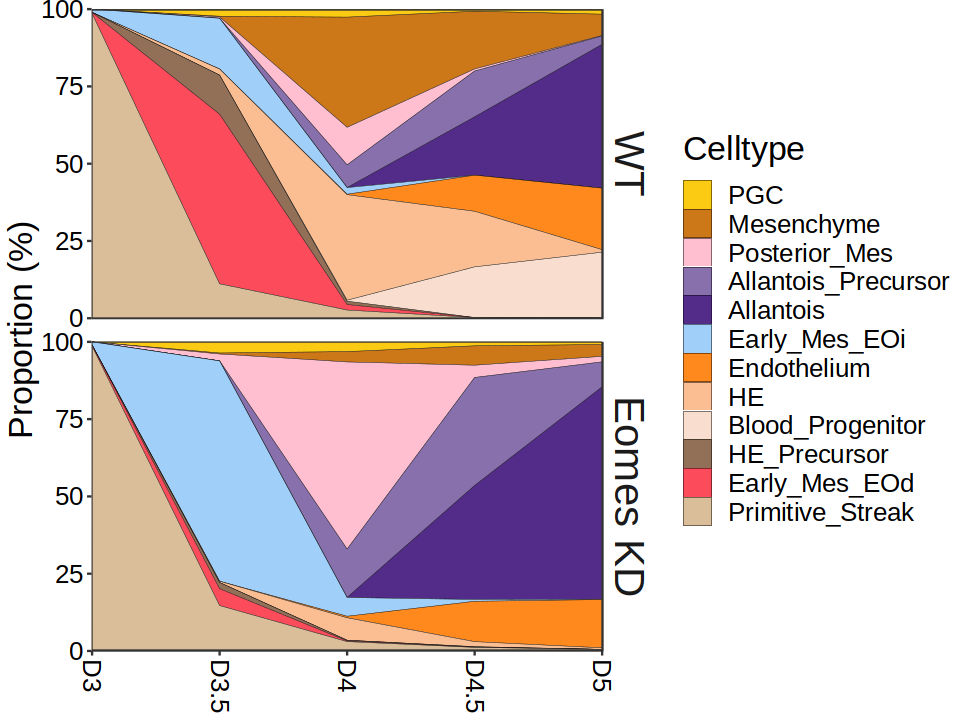

In [18]:
options(repr.plot.width=8, repr.plot.height=6)
p = ggplot(celltype_proportions, aes(day, proportion*100, group=celltype_v2, fill=celltype_v2)) + 
    geom_area(color='black', linewidth=0.1) + 
    scale_fill_manual(values=opts$celltype_v2.colors, name = 'Celltype') + 
    facet_wrap(~genotype, ncol=1, strip.position = 'right') +
    ylab('Proportion (%)') +
    scale_x_discrete(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    theme_bw() + 
    theme(strip.background = element_blank(),
          strip.text = element_text(size=25),
          axis.text = element_text(size=15, color='black'),
          axis.text.x = element_text(angle=-90, hjust=0, vjust=0.5),
          axis.title.y = element_text(size=20),
          axis.title.x = element_blank(),
          legend.text = element_text(size=15, color='black'),
          legend.title = element_text(size=20),
          panel.spacing = unit(0.5, "cm"))
p